# Hypothesis Testing for Insurance Risk Analytics

This notebook explores statistical hypothesis testing to validate risk differences across:
- Provinces
- Zip codes (postal codes)
- Gender

## Objectives

Test the following null hypotheses:
1. **H₀: There are no risk differences across provinces**
2. **H₀: There are no risk differences between zip codes**
3. **H₀: There is no significant margin (profit) difference between zip codes**
4. **H₀: There is no significant risk difference between Women and Men**

## Statistical Tests Used

- **Claim Frequency**: Chi-square test (categorical data)
- **Claim Severity**: ANOVA (if normal) or Kruskal-Wallis (if non-normal)
- **Two Groups**: t-test (if normal) or Mann-Whitney U (if non-normal)

The module automatically selects parametric vs non-parametric tests based on data distribution.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# Import our hypothesis testing module
from hypothesis_testing import HypothesisTester

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# Visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 1. Load Data


In [2]:
# Load processed data
data_path = '../data/processed/insurance_data_final_cleaned.parquet'

print(f"Loading data from: {data_path}")
df = pd.read_parquet(data_path)

print(f"\nData loaded:")
print(f"  • Rows: {df.shape[0]:,}")
print(f"  • Columns: {df.shape[1]:,}")
print(f"  • Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Check required columns
required_cols = ['province', 'postalcode', 'gender', 'totalclaims', 'totalpremium']
missing = [col for col in required_cols if col not in df.columns]
if missing:
    print(f"\n⚠️  Missing columns: {missing}")
else:
    print(f"\n✅ All required columns present")


Loading data from: ../data/processed/insurance_data_final_cleaned.parquet

Data loaded:
  • Rows: 1,000,098
  • Columns: 54
  • Memory: 2355.2 MB

✅ All required columns present


## 2. Explore Data Distribution

Before running hypothesis tests, let's check if our data is normally distributed. This determines whether we use parametric (ANOVA, t-test) or non-parametric (Kruskal-Wallis, Mann-Whitney U) tests.


Claim Amount Distribution:
  • Policies with claims: 2,788 (0.28%)
  • Mean: R23,273.39
  • Median: R6,140.35
  • Std Dev: R38,719.51
  • Skewness: 3.85
  • Kurtosis: 20.59


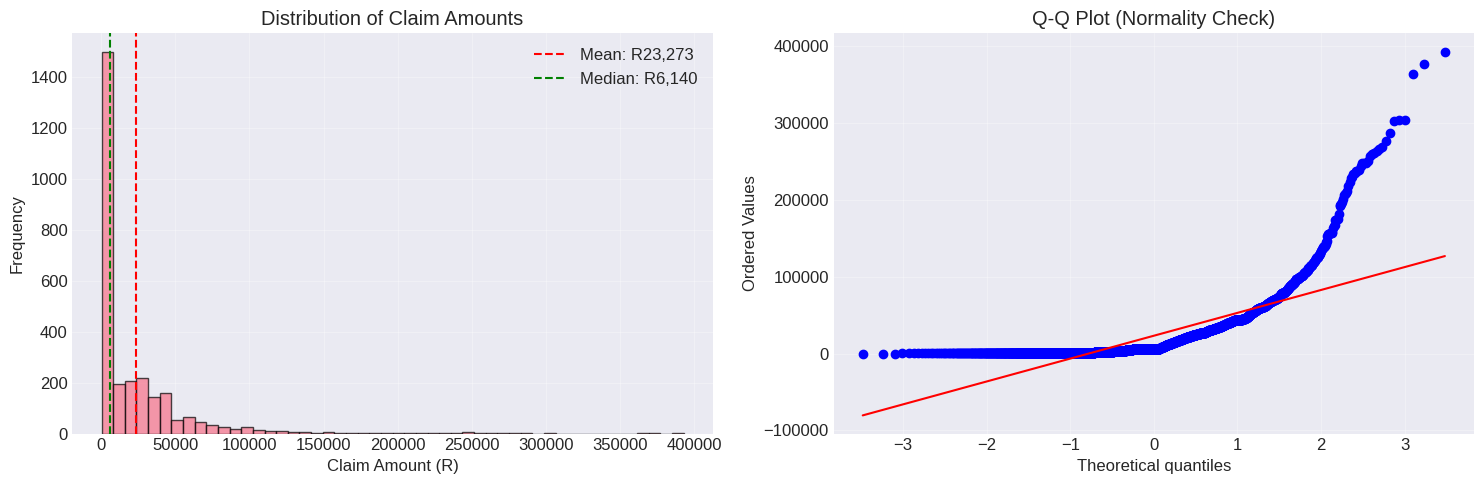


Normality Test (D'Agostino-Pearson): p = 0.0000
  → Data is NOT normally distributed → Use non-parametric tests (Kruskal-Wallis, Mann-Whitney U)


In [3]:
# Check distribution of claim amounts
claims_data = df[df['totalclaims'] > 0]['totalclaims']

print(f"Claim Amount Distribution:")
print(f"  • Policies with claims: {len(claims_data):,} ({len(claims_data)/len(df)*100:.2f}%)")
print(f"  • Mean: R{claims_data.mean():,.2f}")
print(f"  • Median: R{claims_data.median():,.2f}")
print(f"  • Std Dev: R{claims_data.std():,.2f}")
print(f"  • Skewness: {claims_data.skew():.2f}")
print(f"  • Kurtosis: {claims_data.kurtosis():.2f}")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(claims_data, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Claim Amount (R)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Claim Amounts')
axes[0].axvline(claims_data.mean(), color='red', linestyle='--', label=f'Mean: R{claims_data.mean():,.0f}')
axes[0].axvline(claims_data.median(), color='green', linestyle='--', label=f'Median: R{claims_data.median():,.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q plot (to check normality)
from scipy import stats
stats.probplot(claims_data, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test normality
from scipy.stats import normaltest
_, p_norm = normaltest(claims_data.sample(min(5000, len(claims_data)), random_state=42))
print(f"\nNormality Test (D'Agostino-Pearson): p = {p_norm:.4f}")
if p_norm < 0.05:
    print("  → Data is NOT normally distributed → Use non-parametric tests (Kruskal-Wallis, Mann-Whitney U)")
else:
    print("  → Data appears normally distributed → Can use parametric tests (ANOVA, t-test)")


## 3. Initialize Hypothesis Tester


In [4]:
# Initialize tester with significance level α = 0.05
tester = HypothesisTester(df, alpha=0.05)
print("✅ Hypothesis tester initialized")
print(f"   Significance level: α = {tester.alpha}")


✅ Hypothesis tester initialized
   Significance level: α = 0.05


## 4. Test Province Hypotheses

**H₀: There are no risk differences across provinces**


In [5]:
# Run province tests
province_results = tester.test_provinces()

print("\n" + "="*60)
print("PROVINCE HYPOTHESIS TEST RESULTS")
print("="*60)

# Claim frequency test
chi2_p = province_results['chi2_p']
print(f"\n1. Claim Frequency Test (Chi-square):")
print(f"   p-value: {chi2_p:.6f}")
print(f"   Decision: {'REJECT H₀' if chi2_p < 0.05 else 'FAIL TO REJECT H₀'}")
if chi2_p < 0.05:
    print(f"   → Significant differences in claim rates across provinces!")

# Claim severity test
sev_p = province_results['severity_p']
print(f"\n2. Claim Severity Test ({province_results['severity_test']['test_type']}):")
print(f"   p-value: {sev_p:.6f}")
print(f"   Decision: {'REJECT H₀' if sev_p < 0.05 else 'FAIL TO REJECT H₀'}")
print(f"   Test used: {province_results['severity_test']['test_type']}")
if sev_p < 0.05:
    print(f"   → Significant differences in claim amounts across provinces!")

# Display summary statistics
print("\n3. Province Summary Statistics:")
display(province_results['summary'])


Testing province hypotheses...

PROVINCE HYPOTHESIS TEST RESULTS

1. Claim Frequency Test (Chi-square):
   p-value: 0.000000
   Decision: REJECT H₀
   → Significant differences in claim rates across provinces!

2. Claim Severity Test (Kruskal-Wallis):
   p-value: 0.000000
   Decision: REJECT H₀
   Test used: Kruskal-Wallis
   → Significant differences in claim amounts across provinces!

3. Province Summary Statistics:


,policies,claim_rate,totalpremium,totalclaims,loss_ratio,avg_claim_given_claim,margin
province,,,,,,,
Gauteng,393865,0.00,"24,054,871.72","29,406,407.24",1.22,"22,243.88",-13.59
Western Cape,170796,0.00,"9,810,106.93","10,395,464.46",1.06,"28,095.85",-3.43
KwaZulu-Natal,169781,0.00,"13,235,782.89","14,301,382.45",1.08,"29,609.49",-6.28
North West,143287,0.00,"7,490,508.18","5,920,250.00",0.79,"16,963.47",10.96
Mpumalanga,52718,0.00,"2,836,291.94","2,045,382.84",0.72,"15,979.55",15.00
Eastern Cape,30336,0.00,"2,140,302.66","1,356,426.66",0.63,"27,128.53",25.84
Limpopo,24836,0.00,"1,537,324.50","1,016,476.71",0.66,"15,171.29",20.97
Free State,8099,0.00,"521,363.24","354,922.27",0.68,"32,265.66",20.55
Northern Cape,6380,0.00,"316,558.07","89,490.51",0.28,"11,186.31",35.59


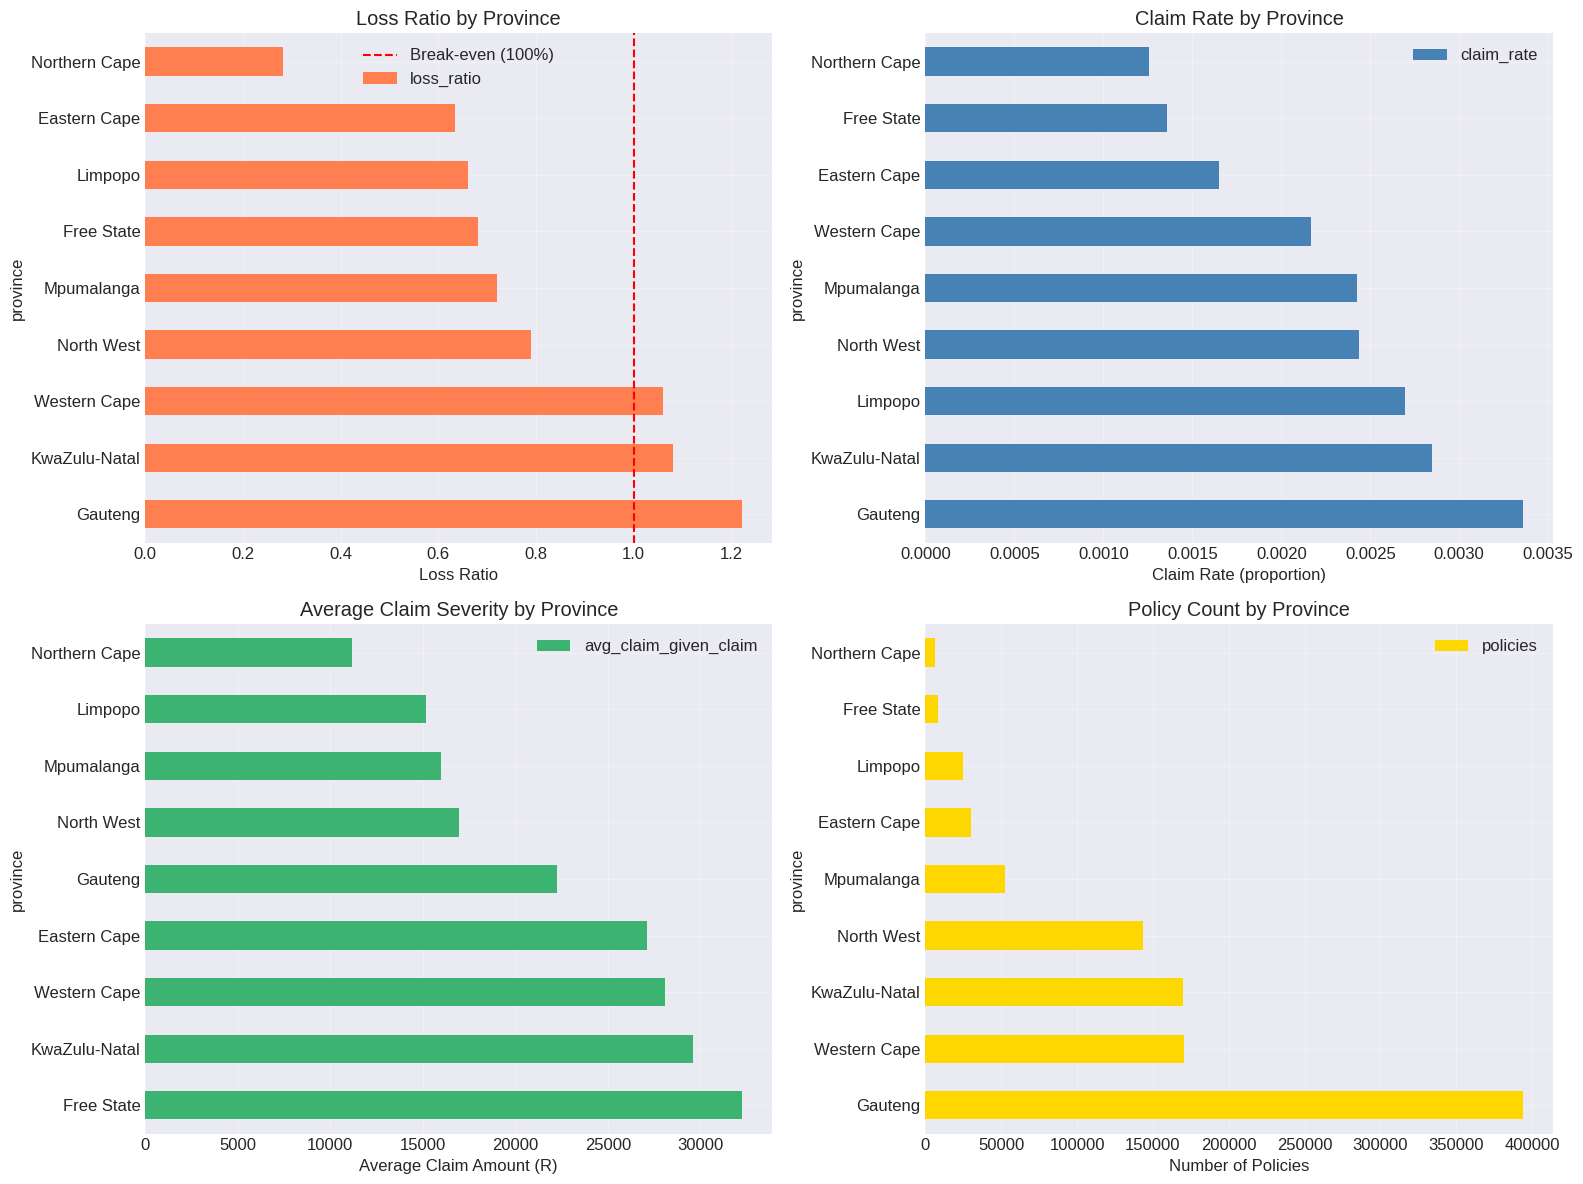

In [6]:
# Visualize province differences
prov_summary = province_results['summary']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss ratio by province
prov_summary.sort_values('loss_ratio', ascending=False).plot(
    y='loss_ratio', kind='barh', ax=axes[0, 0], color='coral'
)
axes[0, 0].set_xlabel('Loss Ratio')
axes[0, 0].set_title('Loss Ratio by Province')
axes[0, 0].axvline(1.0, color='red', linestyle='--', label='Break-even (100%)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Claim rate by province
prov_summary.sort_values('claim_rate', ascending=False).plot(
    y='claim_rate', kind='barh', ax=axes[0, 1], color='steelblue'
)
axes[0, 1].set_xlabel('Claim Rate (proportion)')
axes[0, 1].set_title('Claim Rate by Province')
axes[0, 1].grid(True, alpha=0.3)

# Average claim amount
prov_summary.sort_values('avg_claim_given_claim', ascending=False).plot(
    y='avg_claim_given_claim', kind='barh', ax=axes[1, 0], color='mediumseagreen'
)
axes[1, 0].set_xlabel('Average Claim Amount (R)')
axes[1, 0].set_title('Average Claim Severity by Province')
axes[1, 0].grid(True, alpha=0.3)

# Number of policies
prov_summary.sort_values('policies', ascending=False).plot(
    y='policies', kind='barh', ax=axes[1, 1], color='gold'
)
axes[1, 1].set_xlabel('Number of Policies')
axes[1, 1].set_title('Policy Count by Province')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/province_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


In [7]:
# Run all tests
all_results = tester.run_all_tests()

# Generate comprehensive report
report_path = tester.generate_report('../reports/hypothesis_testing.md')
print(f"\n✅ Report generated: {report_path}")


Running All Hypothesis Tests
Testing province hypotheses...
Testing zip code hypotheses...
Testing gender hypotheses...

✅ Report generated: ../reports/hypothesis_testing.md


## 6. Summary and Business Recommendations


In [8]:
print("="*60)
print("HYPOTHESIS TEST SUMMARY")
print("="*60)

def decision(p, alpha=0.05):
    if pd.isna(p):
        return "Insufficient data"
    return "REJECT H₀" if p < alpha else "FAIL TO REJECT H₀"

print("\n1. PROVINCES:")
print(f"   Frequency: {decision(all_results['provinces']['chi2_p'])} (p={all_results['provinces']['chi2_p']:.6f})")
print(f"   Severity:  {decision(all_results['provinces']['severity_p'])} (p={all_results['provinces']['severity_p']:.6f})")

print("\n2. ZIP CODES:")
print(f"   Frequency: {decision(all_results['zipcodes']['chi2_p'])} (p={all_results['zipcodes']['chi2_p']:.6f})")
print(f"   Severity:  {decision(all_results['zipcodes']['severity_p'])} (p={all_results['zipcodes']['severity_p']:.6f})")
print(f"   Margin:    {decision(all_results['zipcodes']['margin_p'])} (p={all_results['zipcodes']['margin_p']:.6f})")

print("\n3. GENDER:")
print(f"   Frequency: {decision(all_results['gender']['chi2_p'])} (p={all_results['gender']['chi2_p']:.6f})")
print(f"   Severity:  {decision(all_results['gender']['severity_p'])} (p={all_results['gender']['severity_p']:.6f})")

print("\n" + "="*60)
print("BUSINESS RECOMMENDATIONS")
print("="*60)

rejected = []
if all_results['provinces']['chi2_p'] < 0.05 or all_results['provinces']['severity_p'] < 0.05:
    rejected.append("✓ Implement province-based pricing tiers")
if all_results['zipcodes']['chi2_p'] < 0.05 or all_results['zipcodes']['severity_p'] < 0.05:
    rejected.append("✓ Develop granular zip code-based pricing")
if all_results['zipcodes']['margin_p'] < 0.05:
    rejected.append("✓ Investigate unprofitable zip codes for pricing adjustments")
if all_results['gender']['chi2_p'] < 0.05:
    rejected.append("✓ Consider gender in risk models (verify legal compliance)")

if rejected:
    print("\nBased on rejected hypotheses:")
    for rec in rejected:
        print(f"  {rec}")
else:
    print("\nNo significant differences detected. Current pricing strategy appears appropriate.")

print("\n" + "="*60)


HYPOTHESIS TEST SUMMARY

1. PROVINCES:
   Frequency: REJECT H₀ (p=0.000000)
   Severity:  REJECT H₀ (p=0.000000)

2. ZIP CODES:
   Frequency: REJECT H₀ (p=0.000000)
   Severity:  REJECT H₀ (p=0.002892)
   Margin:    REJECT H₀ (p=0.000000)

3. GENDER:
   Frequency: FAIL TO REJECT H₀ (p=0.951464)
   Severity:  FAIL TO REJECT H₀ (p=0.223513)

BUSINESS RECOMMENDATIONS

Based on rejected hypotheses:
  ✓ Implement province-based pricing tiers
  ✓ Develop granular zip code-based pricing
  ✓ Investigate unprofitable zip codes for pricing adjustments

